# Reducing and Filtering of Chord-Oddball data

In [1]:
import mne
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, "../")
import ccs_eeg_utils
import numpy as np
import mne.preprocessing as prep
import os
import sklearn 
from contextlib import contextmanager
from autoreject import AutoReject

from mne_bids import (BIDSPath, read_raw_bids, write_raw_bids, inspect_dataset)

%matplotlib qt

# path where dataset is stored
bids_root = "./data/ds003570/"
TASK = 'AuditoryOddballChords'
SUBJECT = '014'
SUPRESS_BIDS_OUTPUT = True

In [2]:
# Context manager to suppress stdout and stderr
@contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def read_raw_data(subject_id):
    bids_path = BIDSPath(subject=subject_id,
                         datatype='eeg', suffix='eeg', task=TASK,
                         root=bids_root)

    if SUPRESS_BIDS_OUTPUT:
        with suppress_stdout_stderr():
            raw = read_raw_bids(bids_path)
    else:
        raw = read_raw_bids(bids_path)

    # Inplace?
    ccs_eeg_utils.read_annotations_core(bids_path, raw)
    raw.load_data()
    
    return raw, bids_path


def preprocessing(raw, bad_channels = []):
    # TODO: bandpass first, downsample later? -> expensive!
    # 1. Downsampling to 64 Hz
    if raw.info['sfreq'] > 64:
        raw.resample(128)

    # Set channel types to EEG if not already set
    if not all(ch_type in ['eeg', 'stim'] for ch_type in raw.get_channel_types()):
        eeg_channel_names = raw.ch_names
        channel_types = {name: 'eeg' for name in eeg_channel_names}
        raw.set_channel_types(channel_types)

    # 2. Band-pass filter between 0.5 Hz and 30 Hz
    raw.filter(0.5, 30, fir_design='firwin')

    # 3. Re-referencing to the average activity of all electrodes
    #TODO: add apply_proj() here to apply arp?
    raw.set_eeg_reference('average', projection=True)

    """ events = prep.find_eog_events(raw)
    print(events) """

    # 4. Bad Channel Interpolations
    # Manually mark some channels as bad (all channels w/ n/a?)
    if bad_channels:
        raw.info['bads'] = bad_channels
    # Interpolate bad channels
    raw.interpolate_bads()

    # 5. Data Reduction (optional)
    # For instance, crop the first 60 seconds of the data

    return raw


def save_preprocessed_data(file_path, raw):
    """
    Saves the preprocessed EEG data to a file.

    Parameters:
    file_path (str): The path where the preprocessed data will be saved.
    raw (mne.io.Raw): The preprocessed MNE Raw object containing EEG data.
    """
    # Check if file_path ends with .fif extension
    if not file_path.endswith('.fif'):
        file_path += '.fif'

    # Save the data
    try:
        raw.save(file_path, overwrite=True)
        print(f"Data saved successfully to {file_path}")
    except Exception as e:
        print(f"Error saving data: {e}")

# see https://neuraldatascience.io/7-eeg/erp_artifacts.html
def get_ica(data):
    data.load_data()
    data.set_montage('standard_1020', match_case=False)
    ica= mne.preprocessing.ICA(method="fastica")
    ica.fit(data, verbose=True)
    ica.plot_components()
    ica.plot_properties(data, picks=[3])


In [3]:
raw, bids_path = read_raw_data(SUBJECT)

raw.info

Reading 0 ... 4818943  =      0.000 ...  2353.000 secs...


<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 misc
 custom_ref_applied: False
 dig: 3 items (3 Cardinal)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 1024.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 2048.0 Hz
 subject_info: 5 items (dict)
>

Using matplotlib as 2D backend.


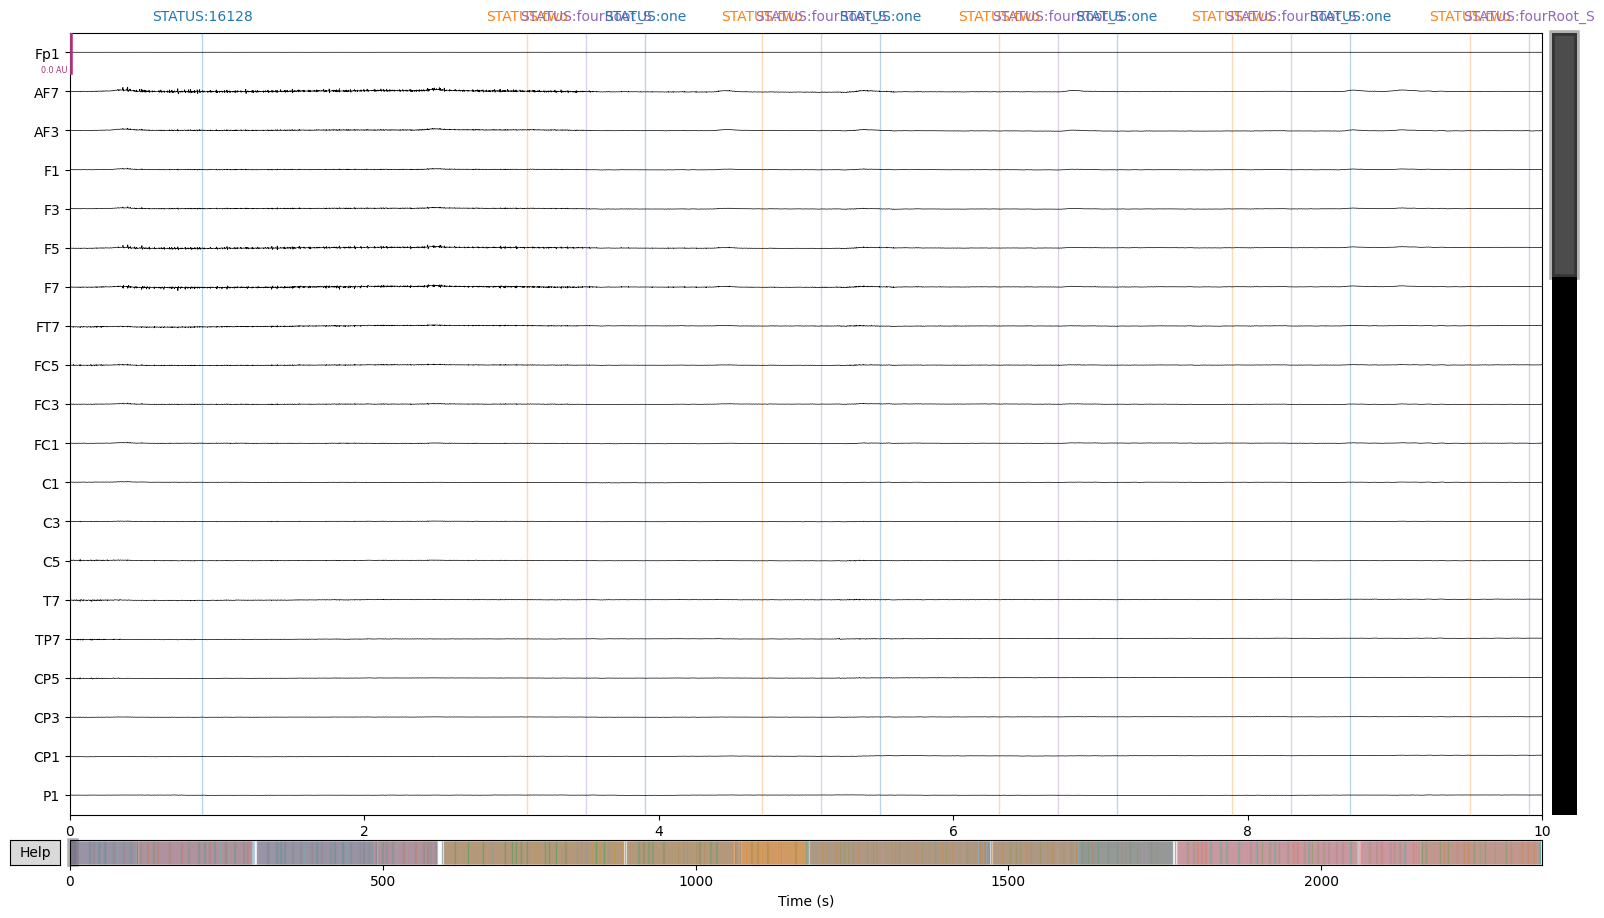

In [4]:
raw.plot()

In [5]:
# reduce bids eeg data
prep_raw = preprocessing(raw.copy())

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 31.00 Hz)
- Filter length: 423 samples (6.609 s)



C:\Users\mauff\AppData\Local\Temp\ipykernel_13428\1332446695.py:43: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, Afz, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FCz, FT7, FT8, Fp1, Fp2, Fpz, Fz, Iz, O1, O2, Oz, P1, P10, P2, P3, P4, P5, P6, P7, P8, P9, PO3, PO4, PO7, PO8, POz, Pz, T7, T8, TP7, TP8 has changed from NA to V.
  raw.set_channel_types(channel_types)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


C:\Users\mauff\AppData\Local\Temp\ipykernel_13428\1332446695.py:60: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


In [6]:
# save preprocessed data
#TODO: Care about naming conventions?
save_path = f'./data/processed_subject{SUBJECT}.fif'
save_preprocessed_data(save_path, prep_raw)

Overwriting existing file.
Writing d:\Uni\1_Semester\EEG\eeg-chord-oddball\data\processed_subject014.fif


C:\Users\mauff\AppData\Local\Temp\ipykernel_13428\1332446695.py:82: RuntimeWarning: This filename (d:\Uni\1_Semester\EEG\eeg-chord-oddball\data\processed_subject014.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(file_path, overwrite=True)


Closing d:\Uni\1_Semester\EEG\eeg-chord-oddball\data\processed_subject014.fif
[done]
Data saved successfully to ./data/processed_subject014.fif


In [7]:
series = prep_raw[0,:]
#print(series[0][0])
plt.plot(series[0][0])
plt.show()
plt.plot(series[0][0])
plt.show()

## Epochs

In [8]:
# test with some electrodes

raw_subselect = prep_raw.copy().pick(["Cz", "T7", "T8", "P3", "P4"])
raw_subselect.annotations

<Annotations | 4523 segments: STATUS:16128 (8), STATUS:Correct - Exemplar! ...>

In [9]:
# TODO: Copied from exercise 1, has to be adapted. Change selection of electrodes to electrodes near the ears? --> Cz is apparently connected to N2c
evts,evts_dict = mne.events_from_annotations(raw_subselect)

# not sure what annotations to use here
# wanted_keys = [e for e in evts_dict.keys() if 'STATUS:two' in e]

# deviant events (get all deviant events)
deviant_keys = [e for e in evts_dict.keys() if 'deviant' in e]

evts_dict_stim=dict((k, evts_dict[k]) for k in deviant_keys if k in evts_dict)

print(evts_dict_stim)



Used Annotations descriptions: ['STATUS:16128', 'STATUS:Correct - Exemplar!', 'STATUS:Correct - Function!', 'STATUS:Incorrect - Standard!', 'STATUS:boundary', 'STATUS:five6_S', 'STATUS:five6_deviantE', 'STATUS:five6_deviantEcorrect_E', 'STATUS:five6_deviantF', 'STATUS:five6_deviantFcorrect_F', 'STATUS:fiveRoot_S', 'STATUS:fiveRoot_deviantE', 'STATUS:fiveRoot_deviantEcorrect_E', 'STATUS:fiveRoot_deviantF', 'STATUS:fiveRoot_deviantFcorrect_F', 'STATUS:four6_S', 'STATUS:four6_Sincorrect', 'STATUS:four6_deviantE', 'STATUS:four6_deviantEcorrect_E', 'STATUS:four6_deviantF', 'STATUS:four6_deviantFcorrect_F', 'STATUS:fourRoot_S', 'STATUS:fourRoot_Sincorrect', 'STATUS:fourRoot_deviantE', 'STATUS:fourRoot_deviantEcorrect_E', 'STATUS:fourRoot_deviantF', 'STATUS:fourRoot_deviantFcorrect_F', 'STATUS:one', 'STATUS:two']
{'STATUS:five6_deviantE': 7, 'STATUS:five6_deviantEcorrect_E': 8, 'STATUS:five6_deviantF': 9, 'STATUS:five6_deviantFcorrect_F': 10, 'STATUS:fiveRoot_deviantE': 12, 'STATUS:fiveRoot_d

In [10]:

# 400 ms before stimulus onset, 1600 ms after stimulus onset - Stimulus 2 --> since each chord lasts 400ms --> 0s - 2000
# maybe add baseline=(0.3,0.4) according to paper --> then no ica though? -> why?
raw_subselect.info.normalize_proj()

# EITHER use total threshold -250uV - 250uV 
reject = dict(eeg=0.0005) # in V
epochs = mne.Epochs(raw_subselect, evts, evts_dict_stim, tmin=-0.4, tmax=1.6, baseline=(0,0.4), preload=True, reject=reject)

# OR use annotations
""" annotations, bads = prep.annotate_amplitude(raw_subselect, flat=dict(eeg=-250 * 1e-6), peak=dict(eeg=250 * 1e-6), picks="eeg")
raw_subselect.set_annotations(annotations)
epochs = mne.Epochs(raw_subselect, evts, evts_dict_stim, tmin=-0.4, tmax=1.6, baseline=(0.3,0.4), preload=True, reject_by_annotation=True) """


# remove deviant epochs with reaction time under 200ms
correct_keys = [e for e in evts_dict.keys() if 'correct' in e]
correct_evt_ids = [evts_dict[key] for key in correct_keys]

# get all event times
event_times = epochs.events[:, 0] / epochs.info['sfreq']

# if a correct event exists less than 600ms in the epoch (epochs starts 400ms before deviant + 200ms reactiontime), remove deviant event
epochs_to_remove = []
for i in range(len(event_times) - 1):
    current_time = event_times[i]
    next_time = event_times[i + 1]

    # Check if the next event is a correct one and within 600ms
    if (epochs.events[i + 1, 2] in correct_evt_ids and 
        (next_time - current_time) < 0.6):
        epochs_to_remove.append(i)


# Remove the epochs with unrealistic (<200ms) reaction time
epochs_to_keep = [i for i in range(len(epochs)) if i not in epochs_to_remove]
epochs = epochs[epochs_to_keep]

# TODO: ICA vor oder nach Epoching?
ica = get_ica(prep_raw)
#ica = get_ica(epochs)

# extract data from epochs object
data = epochs.get_data()
times = epochs.times

n_trials = 3 # use data.shape[0] for all
fig, axs = plt.subplots(n_trials, 1, figsize=(10, 3*n_trials), sharex=True, sharey=True)

# plot selected trials
for i in range(n_trials):
    for ch in range(data.shape[1]):
        axs[i].plot(times, data[i, ch, :], label=f'Channel {ch}')
    axs[i].set_title(f'Trial {i}')
    axs[i].legend(loc='upper right')

# label the x-axis
plt.xlabel('Time (s)')

# display the plot
plt.show()



Not setting metadata
220 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 220 events and 129 original time points ...


0 bad epochs dropped
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 63 components
Fitting ICA took 15.8s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1176 matching events found
No baseline correction applied
0 projection items activated


In [16]:
epochs_concat = np.array(epochs)
concat = []
epochs_concat_removed = []
removed = 0

for index, epoch in enumerate(epochs_concat[:]):
    for channel in epoch:
        concat = np.concatenate((concat, channel))
    mean_concat = np.mean(concat)
    std_concat = np.std(concat)
    for signal in concat:
        if(signal > mean_concat - (5 * std_concat) and signal < mean_concat + (5 * std_concat) or signal < (-250 * 1e-6) or signal > (250 * 1e-6)):
            epochs_concat_removed.append(signal)

print("len after: ", len(epochs_concat_removed))

len after:  15661145


In [15]:
epochs_channel = np.array(epochs)
print("len prior: ", len(epochs_channel))

for index, epoch in enumerate(epochs_channel):
    for channel in epoch:
        mean_channel = np.mean(channel)
        std_channel = np.std(channel)
        for signal in channel:
            if(signal < mean_channel - (5 * std_channel) or signal > mean_channel + (5 * std_channel) or signal < (-250 * 1e-6) or signal > (250 * 1e-6)):
                print("remove ", signal)
                epochs_channel = np.delete(epochs_channel, index, 0)

print("len after: ", len(epochs_channel))

len prior:  220
remove  -6.135865314597855e-05
len after:  219
